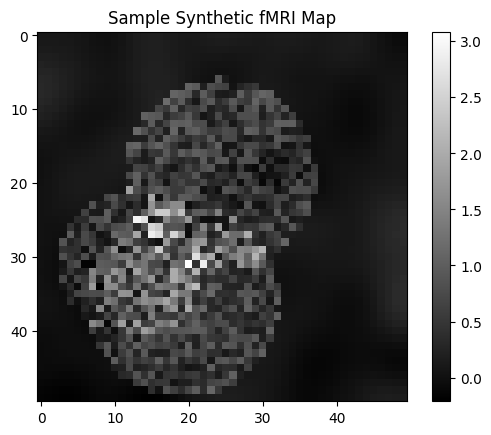

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.ndimage import gaussian_filter

def generate_blob(grid_size, blob_radius, jitter):
    """Generate a single blob with random jitter."""
    center = np.random.randint(blob_radius, grid_size - blob_radius, size=2) + jitter
    y, x = np.ogrid[-center[0]:grid_size-center[0], -center[1]:grid_size-center[1]]
    mask = x**2 + y**2 <= blob_radius**2
    blob = np.zeros((grid_size, grid_size))
    blob[mask] = 1
    return blob

def generate_map(grid_size, max_blobs, jitter):
    """Generate a spatial map with blobs and jitter."""
    map = np.zeros((grid_size, grid_size))
    num_blobs = binom.rvs(n=3, p=0.5, size=1)[0]  # Binomial distribution for number of blobs
    blob_radii = np.random.randint(5, 15, size=num_blobs)  # Random radius for each blob

    for _ in range(max_blobs):
        if num_blobs > 0:
            radius = np.random.choice(blob_radii)
            blob = generate_blob(grid_size, radius, jitter)
            map += blob  # Add blob to the map

    return map

def generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size):
    """Generate synthetic fMRI data for multiple subjects."""
    data = np.zeros((subjects, maps_per_subject, grid_size, grid_size, time_points))

    for subject in range(subjects):
        jitter = np.random.normal(0, 1, 2)  # Gaussian-distributed jitter
        for map_index in range(maps_per_subject):
            spatial_map = generate_map(grid_size, max_blobs=3, jitter=jitter)
            for time_point in range(time_points):
                time_series = np.random.rand(grid_size, grid_size)
                noise = gaussian_filter(np.random.randn(grid_size, grid_size), sigma=3)
                data[subject, map_index, :, :, time_point] = spatial_map * time_series + noise

    return data

# Parameters
subjects = 12
maps_per_subject = 5
time_points = 150
grid_size = 50

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size)

# Visualize one of the generated maps
plt.imshow(synthetic_data[0, 3, :, :, 0], cmap='gray')
plt.title("Sample Synthetic fMRI Map")
plt.colorbar()
plt.show()
